In [56]:
# 分类模型训练

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [5]:
def get_data_loader(root, batch_size, for_train=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307), (0.3081))
    ])
    
    dataset = datasets.MNIST(
        root = root,
        train = for_train,
        transform = transform,
        download=True
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=for_train
    )
    
    return loader

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 1. (b, 1, 28, 28) -> (b, 16, 24, 24) -> (b, 16, 12, 12)
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        # 2. (b, 16, 12, 12) -> dropout ->(b, 32, 10, 10) -> (b, 32, 5, 5)
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        # 3. (b, 800) -> (b, 160)
        self.fc1 = nn.Sequential(
            nn.Linear(800, 160),
            nn.ReLU(),
            nn.Dropout()
        )
        
        # 4. (b, 160) -> (b, 10)
        self.fc2 = nn.Sequential(
            nn.Linear(160, 10),
            nn.LogSoftmax(dim=-1)
        )
        
    def forward(self, x):
        """
        x: (batch_size, 1, 28, 28)
        """
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [9]:
def test(net, test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    length = 0
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = net(x)
            # print(x.shape, y.shape, y_hat.shape)
            test_loss += nn.functional.nll_loss(y_hat, y)
            pred = torch.argmax(y_hat, dim=-1)
            correct += torch.eq(pred, y).sum()
            length += pred.numel()
        print("total correct rate: {}\n".format(correct / length))
    return correct / length

def train(net, optimizer, n_epochs, train_loader, test_loader, log_interval):
    train_loss = []
    
    for epoch in range(n_epochs):
        net.train()
        for index, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_hat = net(x)
            loss = nn.functional.nll_loss(y_hat, y)
            loss.backward()
            optimizer.step()
            
            if index % log_interval == 0:
                print("epoch: {}\t batch: {}\t loss: {}".format(epoch, index, loss.item()))
                train_loss.append(loss.item())

        torch.save(net.state_dict(), "./model.pth")

        test(net, test_loader)
        
    return train_loss

In [11]:
batch_size_train = 64
batch_size_test = 10000
n_epochs = 5
learning_rate = 0.01
momentum = 0.5
log_interval = 20
random_seed = 1
torch.manual_seed(random_seed)

In [12]:
train_loader = get_data_loader("./data", batch_size_train)
test_loader = get_data_loader("./data", batch_size_test, for_train=False)

net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

history = train(net, optimizer, n_epochs, train_loader, test_loader, log_interval)

epoch: 0, batch: 0, loss: 2.3077845573425293
epoch: 0, batch: 20, loss: 2.2543296813964844
epoch: 0, batch: 40, loss: 2.219815969467163
epoch: 0, batch: 60, loss: 2.1035385131835938
epoch: 0, batch: 80, loss: 1.8287943601608276
epoch: 0, batch: 100, loss: 1.4423524141311646
epoch: 0, batch: 120, loss: 1.0698721408843994
epoch: 0, batch: 140, loss: 1.1722277402877808
epoch: 0, batch: 160, loss: 0.9615517854690552
epoch: 0, batch: 180, loss: 0.6868805885314941
epoch: 0, batch: 200, loss: 0.8532083034515381
epoch: 0, batch: 220, loss: 0.6713714003562927
epoch: 0, batch: 240, loss: 0.6038135886192322
epoch: 0, batch: 260, loss: 0.846162736415863
epoch: 0, batch: 280, loss: 0.5345088839530945
epoch: 0, batch: 300, loss: 0.5540302991867065
epoch: 0, batch: 320, loss: 0.5837243795394897
epoch: 0, batch: 340, loss: 0.49168822169303894
epoch: 0, batch: 360, loss: 0.5275545716285706
epoch: 0, batch: 380, loss: 0.5368872880935669
epoch: 0, batch: 400, loss: 0.40501806139945984
epoch: 0, batch: 42

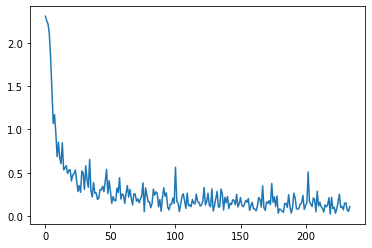

In [14]:
plt.plot(list(range(len(history))), history)

# FGSM 攻击

In [71]:
def perturb_fgsm(epsilon):
    def func(x):
        """
        x: 样本
        """
        sign_data_grad = x.grad.data.sign()
        perturbed_image = x + epsilon * sign_data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        return perturbed_image
    return func


def test_and_attack(net, test_loader, perturb, flag_target=False, label=None):
    """生成对抗样本

    Args:
        net (): 网络
        test_loader (): 测试集
        perturb (): 扰动方法
        flag_target (bool, optional): 是否确定攻击目标，若是，则攻击目标为，将图像错误识别为label参数指定的目标. Defaults to False.
        label (int, optional): 指定攻击目标. Defaults to None.

    Returns:
        tuple: (攻击后的准确率， 对抗样本)
    """
    adv_examples = []
    first_correct_number = 0
    total_number = 0
    attack_success_number = 0
    for x, target in test_loader:
        total_number += 1
        
        x.requires_grad = True
        output = net(x)
        first_pred = torch.argmax(output, dim=-1)

        if first_pred.item() == target.item():
            # 预测对了，才进行攻击，否则不攻击
            first_correct_number += 1
            
            if flag_target:
                assert label is not None, "指定label"
                # assert type(label)
                loss = -nn.functional.nll_loss(output, torch.tensor(label).view_as(target))
            else: 
                loss = nn.functional.nll_loss(output, target)
            net.zero_grad()
            loss.backward()
            
            perturbed_x = perturb(x)
            output = net(perturbed_x)
            second_pred = torch.argmax(output, dim=-1)
            
            if second_pred.item() == target.item():
                # 攻击仍然失败
                pass
            else:
                if flag_target:
                    # 如果定目标攻击，只保存对特定目标的误判
                    if second_pred.item() == label:
                        # 攻击成功，最多保存10个成功案例用于分析
                        attack_success_number += 1
                        if (len(adv_examples) < 10):
                            raw = x.squeeze().detach().cpu().numpy()
                            adv = perturbed_x.squeeze().detach().cpu().numpy()
                            adv_examples.append((first_pred.item(), second_pred.item(), raw, adv))
                else:
                    attack_success_number += 1
                    if (len(adv_examples) < 10):
                        raw = x.squeeze().detach().cpu().numpy()
                        adv = perturbed_x.squeeze().detach().cpu().numpy()
                        adv_examples.append((first_pred.item(), second_pred.item(), raw, adv))
        
    #计算准确率
    s = "total / attack / success: {} / {} / {} \t total accuracy: {}".format(
        total_number, first_correct_number, attack_success_number, 
        (first_correct_number - attack_success_number) / total_number
    )
    print(s)
    
    #返回准确率和攻击样例
    return (first_correct_number - attack_success_number) / total_number, adv_examples

In [74]:
pretrained_net = Net()
pretrained_net.load_state_dict(torch.load("./model.pth"))
test(pretrained_net, get_data_loader("./data", 10000, False))


total correct rate: 0.9837999939918518


In [75]:
epsilons = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

accuracies = []
examples = []
for eps in epsilons:
    print("args: epsilon {}".format(eps), end="\t")
    acc, ex = test_and_attack(
        pretrained_net, 
        get_data_loader("./data", 1, False), 
        perturb_fgsm(eps), 
        flag_target=False, 
        label=2
    )
    accuracies.append(acc)
    examples.append(ex)

args: epsilon 0.2	total / attack / success: 10000 / 9838 / 134 	 total accuracy: 0.9704
args: epsilon 0.25	total / attack / success: 10000 / 9838 / 164 	 total accuracy: 0.9674
args: epsilon 0.3	total / attack / success: 10000 / 9838 / 202 	 total accuracy: 0.9636
args: epsilon 0.35	total / attack / success: 10000 / 9838 / 253 	 total accuracy: 0.9585
args: epsilon 0.4	total / attack / success: 10000 / 9838 / 311 	 total accuracy: 0.9527
args: epsilon 0.5	total / attack / success: 10000 / 9838 / 776 	 total accuracy: 0.9062


In [76]:
epsilons = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

accuracies = []
examples = []
for eps in epsilons:
    print("args: epsilon {}".format(eps), end="\t")
    acc, ex = test_and_attack(
        pretrained_net, 
        get_data_loader("./data", 1, False), 
        perturb_fgsm(eps), 
        flag_target=True, 
        label=2
    )
    accuracies.append(acc)
    examples.append(ex)

args: epsilon 0.2	total / attack / success: 10000 / 9838 / 18 	 total accuracy: 0.982
args: epsilon 0.25	total / attack / success: 10000 / 9838 / 22 	 total accuracy: 0.9816
args: epsilon 0.3	total / attack / success: 10000 / 9838 / 29 	 total accuracy: 0.9809
args: epsilon 0.35	total / attack / success: 10000 / 9838 / 36 	 total accuracy: 0.9802
args: epsilon 0.4	total / attack / success: 10000 / 9838 / 47 	 total accuracy: 0.9791
args: epsilon 0.5	total / attack / success: 10000 / 9838 / 129 	 total accuracy: 0.9709


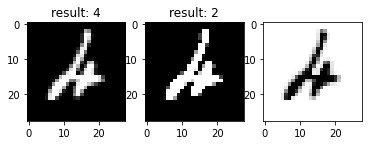

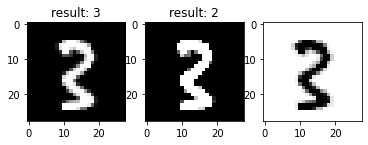

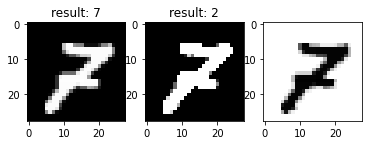

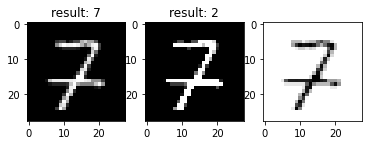

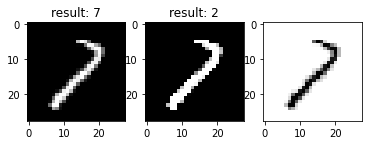

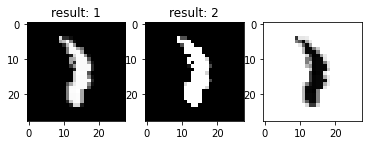

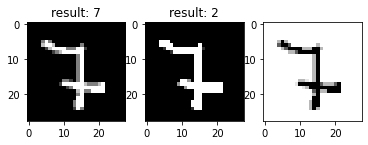

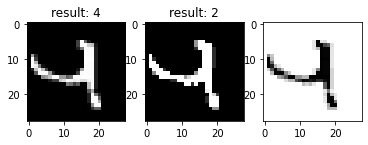

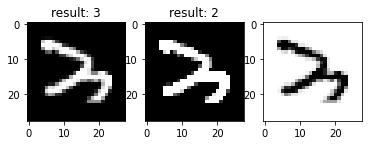

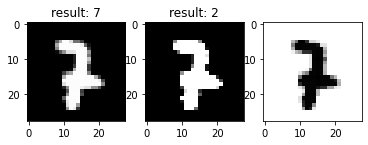

In [73]:
import numpy as np
a = examples[0]
for item in a:
    f, ax = plt.subplots(1, 3)
    
    raw, per = item[2], item[3]
    dif = per - raw
    
    ax[0].imshow(raw, cmap="gray")
    ax[0].set_title("result: {}".format(item[0]))
    ax[1].imshow(per, cmap="gray")
    ax[1].set_title("result: {}".format(item[1]))
    ax[2].imshow(dif, cmap="gray")
    
    plt.show()
